# Phân tích và Phát hiện Truy cập Bất thường trong Mạng

Notebook này sử dụng dataset NSL-KDD để huấn luyện và tối ưu mô hình phát hiện truy cập bất thường trong mạng.

In [20]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import average_precision_score, f1_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import joblib
import os

# GPU support
try:
    import cupy as cp
    from cuml.ensemble import RandomForestClassifier as cuRF
    from cuml.preprocessing import StandardScaler as cuScaler
    USE_GPU = True
    print("GPU được hỗ trợ và sẽ được sử dụng")
except ImportError:
    USE_GPU = False
    print("GPU không khả dụng, sử dụng CPU")

# Tắt cảnh báo
import warnings
warnings.filterwarnings('ignore')

GPU không khả dụng, sử dụng CPU


In [21]:
# Tải dataset NSL-KDD
from download_dataset import download_nslkdd

print("Đang tải và xử lý dataset NSL-KDD...")
train_df, test_df = download_nslkdd()

Đang tải và xử lý dataset NSL-KDD...
Đang tải dataset NSL-KDD...
Đang đọc và xử lý dữ liệu...
Đang lưu dữ liệu đã xử lý...
Hoàn thành! Dữ liệu đã được lưu trong thư mục 'data'


## 1. Phân tích Dữ liệu

Thông tin cơ bản về dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  int64  
 2   service                      125973 non-null  int64  
 3   flag                         125973 non-null  int64  
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              

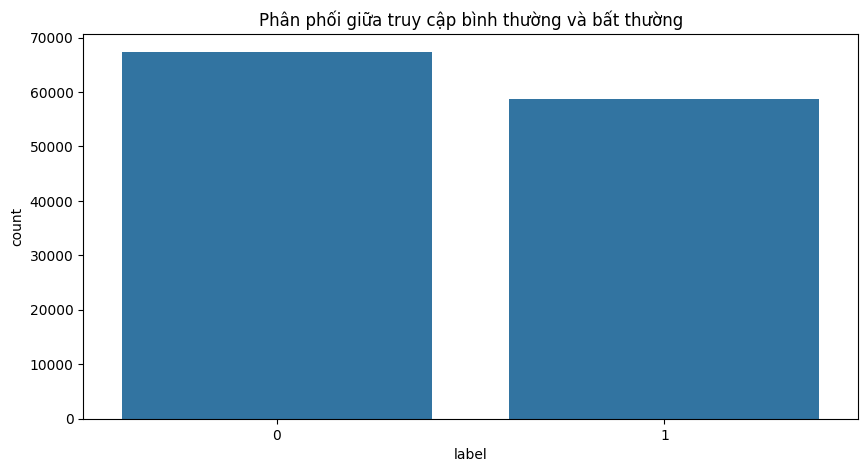


Kiểm tra missing values:
0


In [22]:
def analyze_data(df):
    print("Thông tin cơ bản về dataset:")
    print(df.info())
    
    print("\nPhân phối nhãn:")
    print(df['label'].value_counts(normalize=True))
    
    # Vẽ biểu đồ phân phối nhãn
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x='label')
    plt.title('Phân phối giữa truy cập bình thường và bất thường')
    plt.show()
    
    # Kiểm tra missing values
    print("\nKiểm tra missing values:")
    print(df.isnull().sum().sum())

analyze_data(train_df)

## 2. Tối ưu hóa Mô hình với GPU

In [23]:
def optimize_model_gpu(X_train, y_train, X_test, y_test):
    print("1. Điều chỉnh hyperparameters...")
    
    if USE_GPU:
        # Chuyển dữ liệu sang GPU
        X_train_gpu = cp.array(X_train)
        y_train_gpu = cp.array(y_train)
        X_test_gpu = cp.array(X_test)
        y_test_gpu = cp.array(y_test)
        
        # Sử dụng cuML RandomForest
        rf = cuRF(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )
    else:
        # Sử dụng scikit-learn RandomForest
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1  # Sử dụng tất cả CPU cores
        )
        X_train_gpu = X_train
        y_train_gpu = y_train
        X_test_gpu = X_test
        y_test_gpu = y_test
    
    print("\n2. Huấn luyện mô hình...")
    rf.fit(X_train_gpu, y_train_gpu)
    
    return rf, X_test_gpu, y_test_gpu

# Chuẩn bị dữ liệu
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

# Chuẩn hóa dữ liệu
if USE_GPU:
    scaler = cuScaler()
else:
    scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tối ưu và huấn luyện mô hình
optimized_model, X_test_gpu, y_test_gpu = optimize_model_gpu(X_train_scaled, y_train, X_test_scaled, y_test)

1. Điều chỉnh hyperparameters...

2. Huấn luyện mô hình...


## 3. Đánh giá Mô hình


1. Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.97      0.78      9711
           1       0.97      0.61      0.75     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.79      0.77     22544
weighted avg       0.83      0.77      0.76     22544



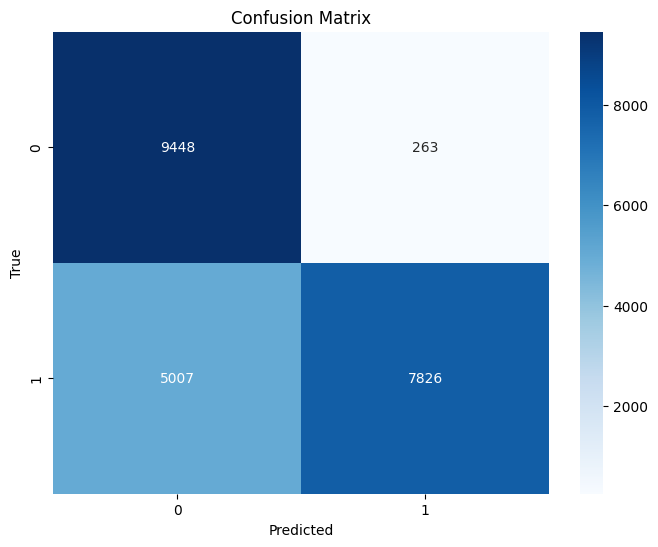

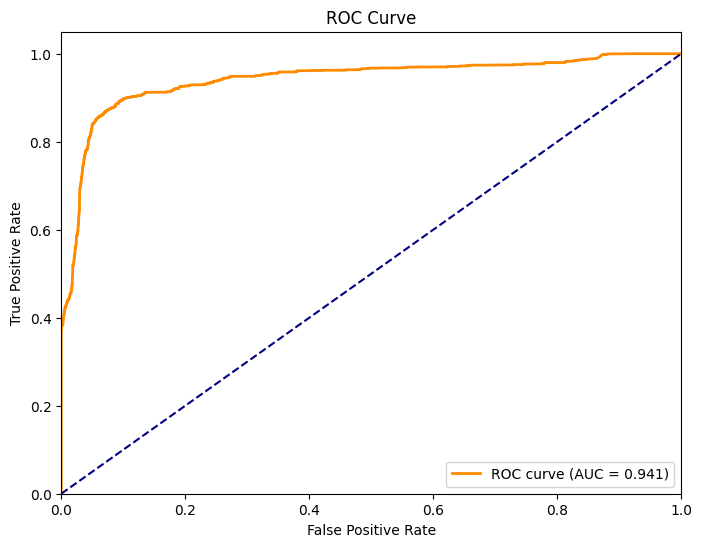

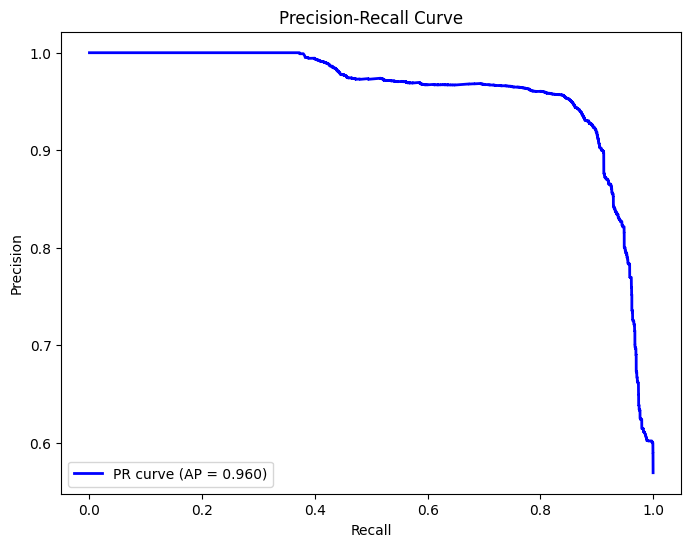

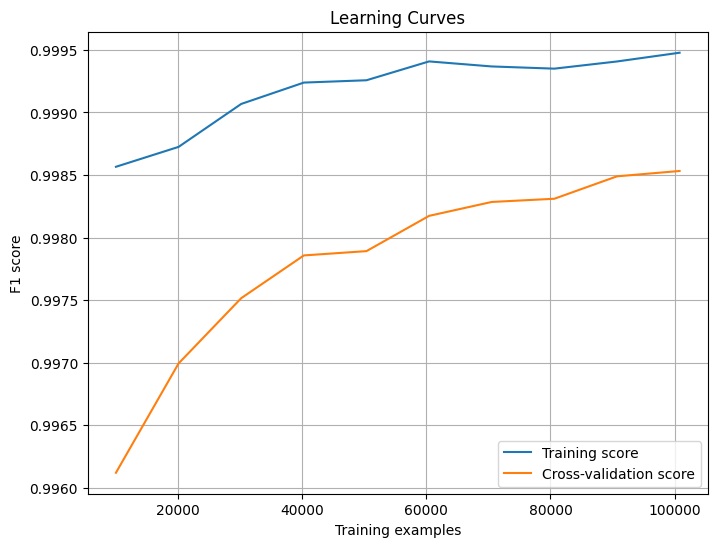


6. Cross-validation F1-scores:
Mean F1: 0.999 (+/- 0.000)


In [24]:
def evaluate_model(model, X_test, y_test):
    # Dự đoán
    y_pred = model.predict(X_test)
    if USE_GPU:
        y_pred = cp.asnumpy(y_pred)
        y_test = cp.asnumpy(y_test)
    
    # 1. Classification Report
    print("\n1. Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # 2. Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # 3. ROC Curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    if USE_GPU:
        y_pred_proba = cp.asnumpy(y_pred_proba)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # 4. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'PR curve (AP = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()
    
    # 5. Learning Curves
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train_scaled, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, scoring='f1', n_jobs=-1
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('F1 score')
    plt.title('Learning Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # 6. Cross-validation Scores
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    print("\n6. Cross-validation F1-scores:")
    print(f"Mean F1: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'f1': f1_score(y_test, y_pred),
        'cv_scores': cv_scores
    }

# Đánh giá mô hình
metrics = evaluate_model(optimized_model, X_test_gpu, y_test_gpu)

## 4. Lưu Mô hình

In [25]:
def save_model(model, scaler, metrics):
    # Tạo thư mục models nếu chưa tồn tại
    if not os.path.exists('models'):
        os.makedirs('models')
    
    print("Đang lưu mô hình và scaler...")
    
    # Lưu metrics
    results = {
        'roc_auc': metrics['roc_auc'],
        'pr_auc': metrics['pr_auc'],
        'f1': metrics['f1'],
        'cv_scores_mean': metrics['cv_scores'].mean(),
        'cv_scores_std': metrics['cv_scores'].std()
    }
    
    # Nếu đang sử dụng GPU, chuyển mô hình về CPU trước khi lưu
    if USE_GPU:
        # Chuyển đổi mô hình GPU sang CPU
        cpu_model = RandomForestClassifier(
            n_estimators=model.n_estimators,
            max_depth=model.max_depth,
            min_samples_split=model.min_samples_split,
            min_samples_leaf=model.min_samples_leaf,
            random_state=42
        )
        cpu_model.fit(cp.asnumpy(X_train_scaled), cp.asnumpy(y_train))
        
        # Chuyển đổi scaler GPU sang CPU
        cpu_scaler = StandardScaler()
        cpu_scaler.fit(X_train)
        
        # Lưu mô hình CPU
        joblib.dump(cpu_model, 'models/rf_model.pkl')
        joblib.dump(cpu_scaler, 'models/scaler.pkl')
    else:
        # Lưu mô hình CPU trực tiếp
        joblib.dump(model, 'models/rf_model.pkl')
        joblib.dump(scaler, 'models/scaler.pkl')
    
    # Lưu metrics
    joblib.dump(results, 'models/metrics.pkl')
    
    print("Đã lưu mô hình thành công!")
    print("\nKết quả đánh giá mô hình:")
    for metric, value in results.items():
        print(f"{metric}: {value:.3f}")

# Lưu mô hình, scaler và metrics
save_model(optimized_model, scaler, metrics)

Đang lưu mô hình và scaler...
Đã lưu mô hình thành công!

Kết quả đánh giá mô hình:
roc_auc: 0.941
pr_auc: 0.960
f1: 0.748
cv_scores_mean: 0.999
cv_scores_std: 0.000
